# SET Pulse Width Prediction Platform

In [34]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import os

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from datetime import datetime
import joblib
import itertools

# Set Matplotlib and Seaborn styles for better visualization
sns.set(style="whitegrid")

## 1. Load and Combine Data from Multiple CSV Files

In [35]:
import os
import pandas as pd

# Define the data directory and the CSV files for each gate type
data_dir = './../data/'

# Dictionary to store all data for each gate type
gate_data_files = {
    'INV': ['inv_Set100_analysis.csv', 'inv_Set150_analysis.csv', 'inv_Set200_analysis.csv', 
            'inv_Set300_analysis.csv', 'inv_Set400_analysis.csv', 'inv_Set500_analysis.csv'],
    'NAND': ['Nand_Set100_analysis.csv', 'Nand_Set200_analysis.csv', 'Nand_Set300_analysis.csv', 
             'Nand_Set400_analysis.csv', 'Nand_Set500_analysis.csv'],
    'NOR': ['Nor_Set100_analysis.csv', 'Nor_Set200_analysis.csv', 'Nor_Set300_analysis.csv', 'Nor_Set500_analysis.csv']
}

## !Notice: the file of "'Nor_Set400_analysis.csv'" doesnot contain any data

# Initialize empty DataFrames to store combined data for each gate type
inv_df = pd.DataFrame()
nand_df = pd.DataFrame()
nor_df = pd.DataFrame()

# Initialize an empty DataFrame to combine all data
combined_df = pd.DataFrame()

# Dictionary to store individual DataFrames for each file
individual_dfs = {}

# Loop through the dictionary to load data for each gate type
for gate_type, files in gate_data_files.items():
    # Initialize a temporary DataFrame to hold gate-specific data
    gate_specific_df = pd.DataFrame()

    for file in files:
        file_path = os.path.join(data_dir, file)
        
        # Load data from CSV
        df = pd.read_csv(file_path)
        
        # Add a column to identify the gate type
        df['gate_type'] = gate_type
        
        # Add a column for the input pulse width extracted from the filename
        df['input_pulse_width'] = int(file.split('_')[1].replace('Set', '').replace('analysis.csv', ''))
        
        # Append to the gate-specific DataFrame
        gate_specific_df = pd.concat([gate_specific_df, df], ignore_index=True)
        
        # Also add this DataFrame to the individual DataFrames dictionary
        individual_dfs[file] = df.copy()

    # Append the gate-specific data to the corresponding DataFrame
    if gate_type == 'INV':
        inv_df = pd.concat([inv_df, gate_specific_df], ignore_index=True)
    elif gate_type == 'NAND':
        nand_df = pd.concat([nand_df, gate_specific_df], ignore_index=True)
    elif gate_type == 'NOR':
        nor_df = pd.concat([nor_df, gate_specific_df], ignore_index=True)
    
    # Append the gate-specific data to the combined DataFrame
    combined_df = pd.concat([combined_df, gate_specific_df], ignore_index=True)


## 2 Dataset Process

### 2.1 Dataset View & Analysis

In [36]:
# Dictionary of available DataFrames for easier selection
dataframes = {
    'inv_df': inv_df,
    'nand_df': nand_df,
    'nor_df': nor_df,
    'combined_df': combined_df,
    'individual_dfs': individual_dfs  # For detailed individual files
}

# Function to display options and information for selected DataFrame
def display_dataframe_info(df_name, show_info=True, show_head=True, show_describe=True):
    if df_name in dataframes:
        df = dataframes[df_name]

        # Show the first few rows of the DataFrame
        if show_head:
            print(f"\nFirst 5 rows of {df_name}:")
            display(df.head())
        
        # Show basic info about the DataFrame
        if show_info:
            print(f"Displaying info for: {df_name}")
            df.info()
        
        # Show descriptive statistics of the DataFrame
        if show_describe:
            print(f"\nDescriptive statistics for {df_name}:")
            print(df.describe())
        
    else:
        print(f"DataFrame '{df_name}' not found.")

# Updated function to support checking individual_dfs
def display_individual_source_file_info(filename, show_info=True, show_head=True, show_describe=True):
    if filename in individual_dfs:
        df = individual_dfs[filename]

        # Show the first few rows of the DataFrame
        if show_head:
            print(f"\nFirst 5 rows of {filename}:")
            display(df.head())
        
        # Show basic info about the DataFrame
        if show_info:
            print(f"Displaying info for: {filename}")
            df.info()
        
        # Show descriptive statistics of the DataFrame
        if show_describe:
            print(f"\nDescriptive statistics for {filename}:")
            print(df.describe())
        
    else:
        print(f"DataFrame '{filename}' not found.")

In [37]:
# Example: Display info, head, and describe for a specific individual DataFrame
display_individual_source_file_info('inv_Set100_analysis.csv')

# Example: Display info, head, and describe for the target dataframe
display_dataframe_info('inv_df')  # You can configure options as needed


First 5 rows of inv_Set100_analysis.csv:


,Starget,Sload,Vdd,Vin,Temperature,Pulse width,gate_type,input_pulse_width
0,0,0,0.8,-0.8,-50,77.33,INV,100
1,0,0,0.8,-0.8,-25,78.36,INV,100
2,0,0,0.8,-0.8,0,79.69,INV,100
3,0,0,0.8,-0.8,25,81.31,INV,100
4,0,0,0.8,-0.8,50,83.09,INV,100


Displaying info for: inv_Set100_analysis.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Starget            5120 non-null   int64  
 1   Sload              5120 non-null   int64  
 2   Vdd                5120 non-null   float64
 3   Vin                5120 non-null   float64
 4   Temperature        5120 non-null   int64  
 5   Pulse width        5120 non-null   float64
 6   gate_type          5120 non-null   object 
 7   input_pulse_width  5120 non-null   int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 320.1+ KB

Descriptive statistics for inv_Set100_analysis.csv:
           Starget        Sload          Vdd          Vin  Temperature  \
count  5120.000000  5120.000000  5120.000000  5120.000000  5120.000000   
mean      7.875000     7.875000     1.000000     0.000000    37.500000   
std       6.972723     6.97272

,Starget,Sload,Vdd,Vin,Temperature,Pulse width,gate_type,input_pulse_width
0,0,0,0.8,-0.8,-50,77.33,INV,100
1,0,0,0.8,-0.8,-25,78.36,INV,100
2,0,0,0.8,-0.8,0,79.69,INV,100
3,0,0,0.8,-0.8,25,81.31,INV,100
4,0,0,0.8,-0.8,50,83.09,INV,100


Displaying info for: inv_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30720 entries, 0 to 30719
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Starget            30720 non-null  int64  
 1   Sload              30720 non-null  int64  
 2   Vdd                30720 non-null  float64
 3   Vin                30720 non-null  float64
 4   Temperature        30720 non-null  int64  
 5   Pulse width        30720 non-null  float64
 6   gate_type          30720 non-null  object 
 7   input_pulse_width  30720 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 1.9+ MB

Descriptive statistics for inv_df:
            Starget         Sload           Vdd           Vin   Temperature  \
count  30720.000000  30720.000000  30720.000000  30720.000000  30720.000000   
mean       7.875000      7.875000      1.000000      0.000000     37.500000   
std        6.972156      6.972156      0.141424  

In [38]:
display_dataframe_info('nand_df')  # You can configure options as needed


First 5 rows of nand_df:


,Starget,Sload,Vdd,Vin,Temperature,Pulse width,gate_type,input_pulse_width
0,0,0,0.8,-0.8,-50,76.19,NAND,100
1,0,0,0.8,-0.8,-25,77.18,NAND,100
2,0,0,0.8,-0.8,0,78.80,NAND,100
3,0,0,0.8,-0.8,25,80.97,NAND,100
4,0,0,0.8,-0.8,50,83.49,NAND,100


Displaying info for: nand_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12800 entries, 0 to 12799
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Starget            12800 non-null  int64  
 1   Sload              12800 non-null  int64  
 2   Vdd                12800 non-null  float64
 3   Vin                12800 non-null  float64
 4   Temperature        12800 non-null  int64  
 5   Pulse width        12800 non-null  float64
 6   gate_type          12800 non-null  object 
 7   input_pulse_width  12800 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 800.1+ KB

Descriptive statistics for nand_df:
            Starget         Sload           Vdd          Vin   Temperature  \
count  12800.000000  12800.000000  12800.000000  12800.00000  12800.000000   
mean       1.750000      7.875000      1.000000      0.00000     37.500000   
std        1.479078      6.972315      0.141427 

In [39]:
display_dataframe_info('nor_df')  # You can configure options as needed


First 5 rows of nor_df:


,Starget,Sload,Vdd,Vin,Temperature,Pulse width,gate_type,input_pulse_width
0,0,0,0.8,-0.8,-50,6.94,NOR,100
1,0,0,0.8,-0.8,-25,7.85,NOR,100
2,0,0,0.8,-0.8,0,8.96,NOR,100
3,0,0,0.8,-0.8,25,10.21,NOR,100
4,0,0,0.8,-0.8,50,11.58,NOR,100


Displaying info for: nor_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Starget            10240 non-null  int64  
 1   Sload              10240 non-null  int64  
 2   Vdd                10240 non-null  float64
 3   Vin                10240 non-null  float64
 4   Temperature        10240 non-null  int64  
 5   Pulse width        10240 non-null  float64
 6   gate_type          10240 non-null  object 
 7   input_pulse_width  10240 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 640.1+ KB

Descriptive statistics for nor_df:
            Starget         Sload           Vdd       Vin   Temperature  \
count  10240.000000  10240.000000  10240.000000  10240.00  10240.000000   
mean       1.750000      7.875000      1.000000      0.00     37.500000   
std        1.479092      6.972383      0.141428      1.01  

In [40]:
display_dataframe_info('combined_df')  # You can configure options as needed


First 5 rows of combined_df:


,Starget,Sload,Vdd,Vin,Temperature,Pulse width,gate_type,input_pulse_width
0,0,0,0.8,-0.8,-50,77.33,INV,100
1,0,0,0.8,-0.8,-25,78.36,INV,100
2,0,0,0.8,-0.8,0,79.69,INV,100
3,0,0,0.8,-0.8,25,81.31,INV,100
4,0,0,0.8,-0.8,50,83.09,INV,100


Displaying info for: combined_df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53760 entries, 0 to 53759
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Starget            53760 non-null  int64  
 1   Sload              53760 non-null  int64  
 2   Vdd                53760 non-null  float64
 3   Vin                53760 non-null  float64
 4   Temperature        53760 non-null  int64  
 5   Pulse width        53760 non-null  float64
 6   gate_type          53760 non-null  object 
 7   input_pulse_width  53760 non-null  int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 3.3+ MB

Descriptive statistics for combined_df:
          Starget         Sload           Vdd          Vin   Temperature  \
count  53760.0000  53760.000000  53760.000000  53760.00000  53760.000000   
mean       5.2500      7.875000      1.000000      0.00000     37.500000   
std        6.1565      6.972107      0.141423   

In [41]:
combined_df

,Starget,Sload,Vdd,Vin,Temperature,Pulse width,gate_type,input_pulse_width
0,0,0,0.8,-0.8,-50,77.33,INV,100
1,0,0,0.8,-0.8,-25,78.36,INV,100
2,0,0,0.8,-0.8,0,79.69,INV,100
3,0,0,0.8,-0.8,25,81.31,INV,100
4,0,0,0.8,-0.8,50,83.09,INV,100
...,...,...,...,...,...,...,...,...
53755,4,20,1.2,1.2,25,594.06,NOR,500
53756,4,20,1.2,1.2,50,594.62,NOR,500
53757,4,20,1.2,1.2,75,594.90,NOR,500
53758,4,20,1.2,1.2,100,594.74,NOR,500


Now, check the data issue of all the dataframes, such as NAN, missing data, etc

In [42]:
# Function to check common data issues
def check_data_issues(df_name):
    if df_name in dataframes:
        df = dataframes[df_name]
        print(f"\nChecking data issues for: {df_name}")
        
        # 1. Missing values check
        missing_values = df.isnull().sum()
        print("\nMissing Values:")
        print(missing_values[missing_values > 0])
        
        # 2. Duplicate values check
        duplicate_rows = df.duplicated().sum()
        print(f"\nNumber of duplicate rows: {duplicate_rows}")
        
        # 3. Descriptive statistics to check for anomalies or outliers
        print("\nDescriptive statistics:")
        print(df.describe())
        
        # 4. Data type check
        print("\nData types:")
        print(df.dtypes)
        
    else:
        print(f"DataFrame '{df_name}' not found.")

# Example: Check data issues for 'inv_df'
check_data_issues('combined_df')


Checking data issues for: combined_df

Missing Values:
Series([], dtype: int64)

Number of duplicate rows: 0

Descriptive statistics:
          Starget         Sload           Vdd          Vin   Temperature  \
count  53760.0000  53760.000000  53760.000000  53760.00000  53760.000000   
mean       5.2500      7.875000      1.000000      0.00000     37.500000   
std        6.1565      6.972107      0.141423      1.00996     57.282729   
min        0.0000      0.000000      0.800000     -1.20000    -50.000000   
25%        1.0000      1.750000      0.900000     -1.00000     -6.250000   
50%        2.0000      6.000000      1.000000      0.00000     37.500000   
75%        8.0000     13.000000      1.100000      1.00000     81.250000   
max       20.0000     20.000000      1.200000      1.20000    125.000000   

        Pulse width  input_pulse_width  
count  53760.000000       53760.000000  
mean     266.768979         280.952381  
std      173.000935         142.659919  
min        0.000

From the above checking, there are NO missing values in all the dataset. BUT, the dataset of "'Nor_Set400_analysis.csv'" is not used.

### 2.2 Figure Analysis of the Source Data

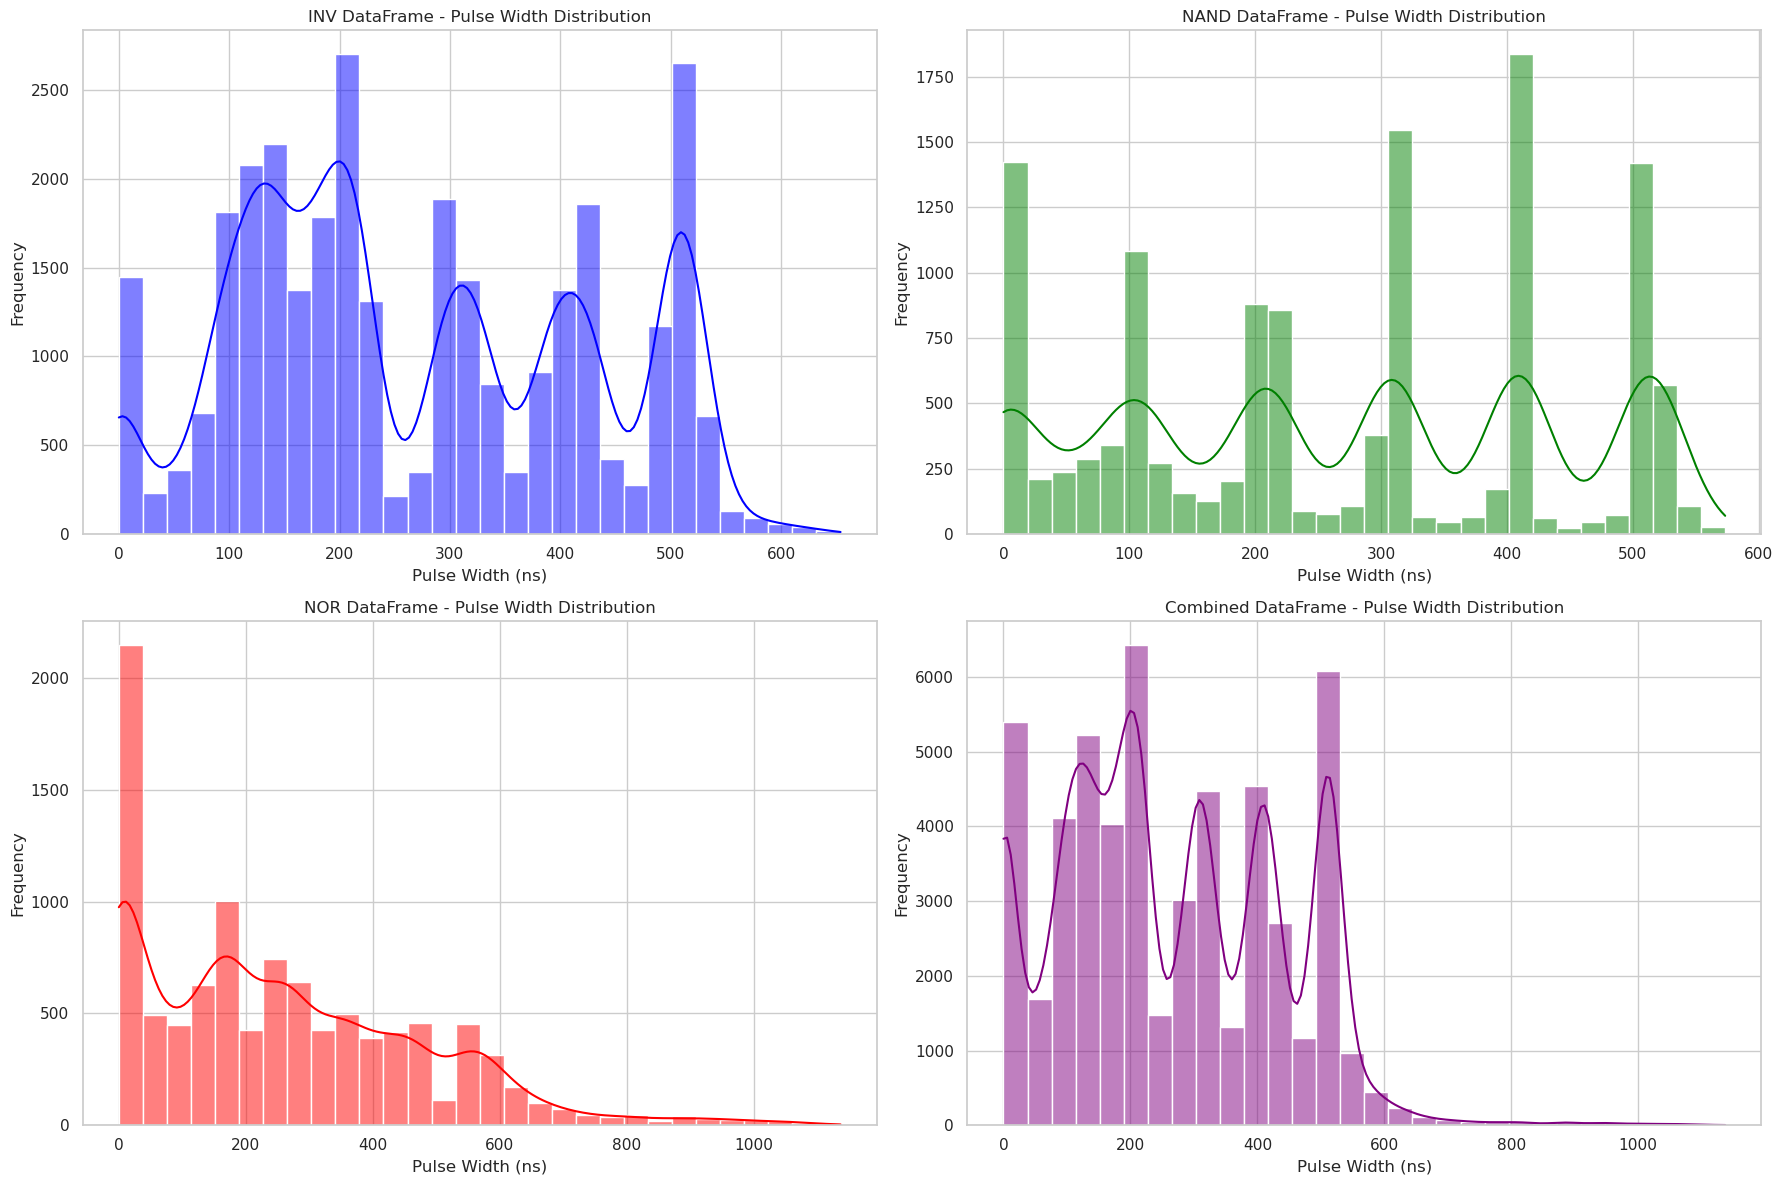

In [43]:
# 1. Pulse Width Distribution Figures for All DataFrames

# Plot pulse width distribution for each dataset
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
sns.histplot(inv_df['Pulse width'], bins=30, kde=True, color='blue')
plt.title('INV DataFrame - Pulse Width Distribution')
plt.xlabel('Pulse Width (ns)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
sns.histplot(nand_df['Pulse width'], bins=30, kde=True, color='green')
plt.title('NAND DataFrame - Pulse Width Distribution')
plt.xlabel('Pulse Width (ns)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(nor_df['Pulse width'], bins=30, kde=True, color='red')
plt.title('NOR DataFrame - Pulse Width Distribution')
plt.xlabel('Pulse Width (ns)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(combined_df['Pulse width'], bins=30, kde=True, color='purple')
plt.title('Combined DataFrame - Pulse Width Distribution')
plt.xlabel('Pulse Width (ns)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

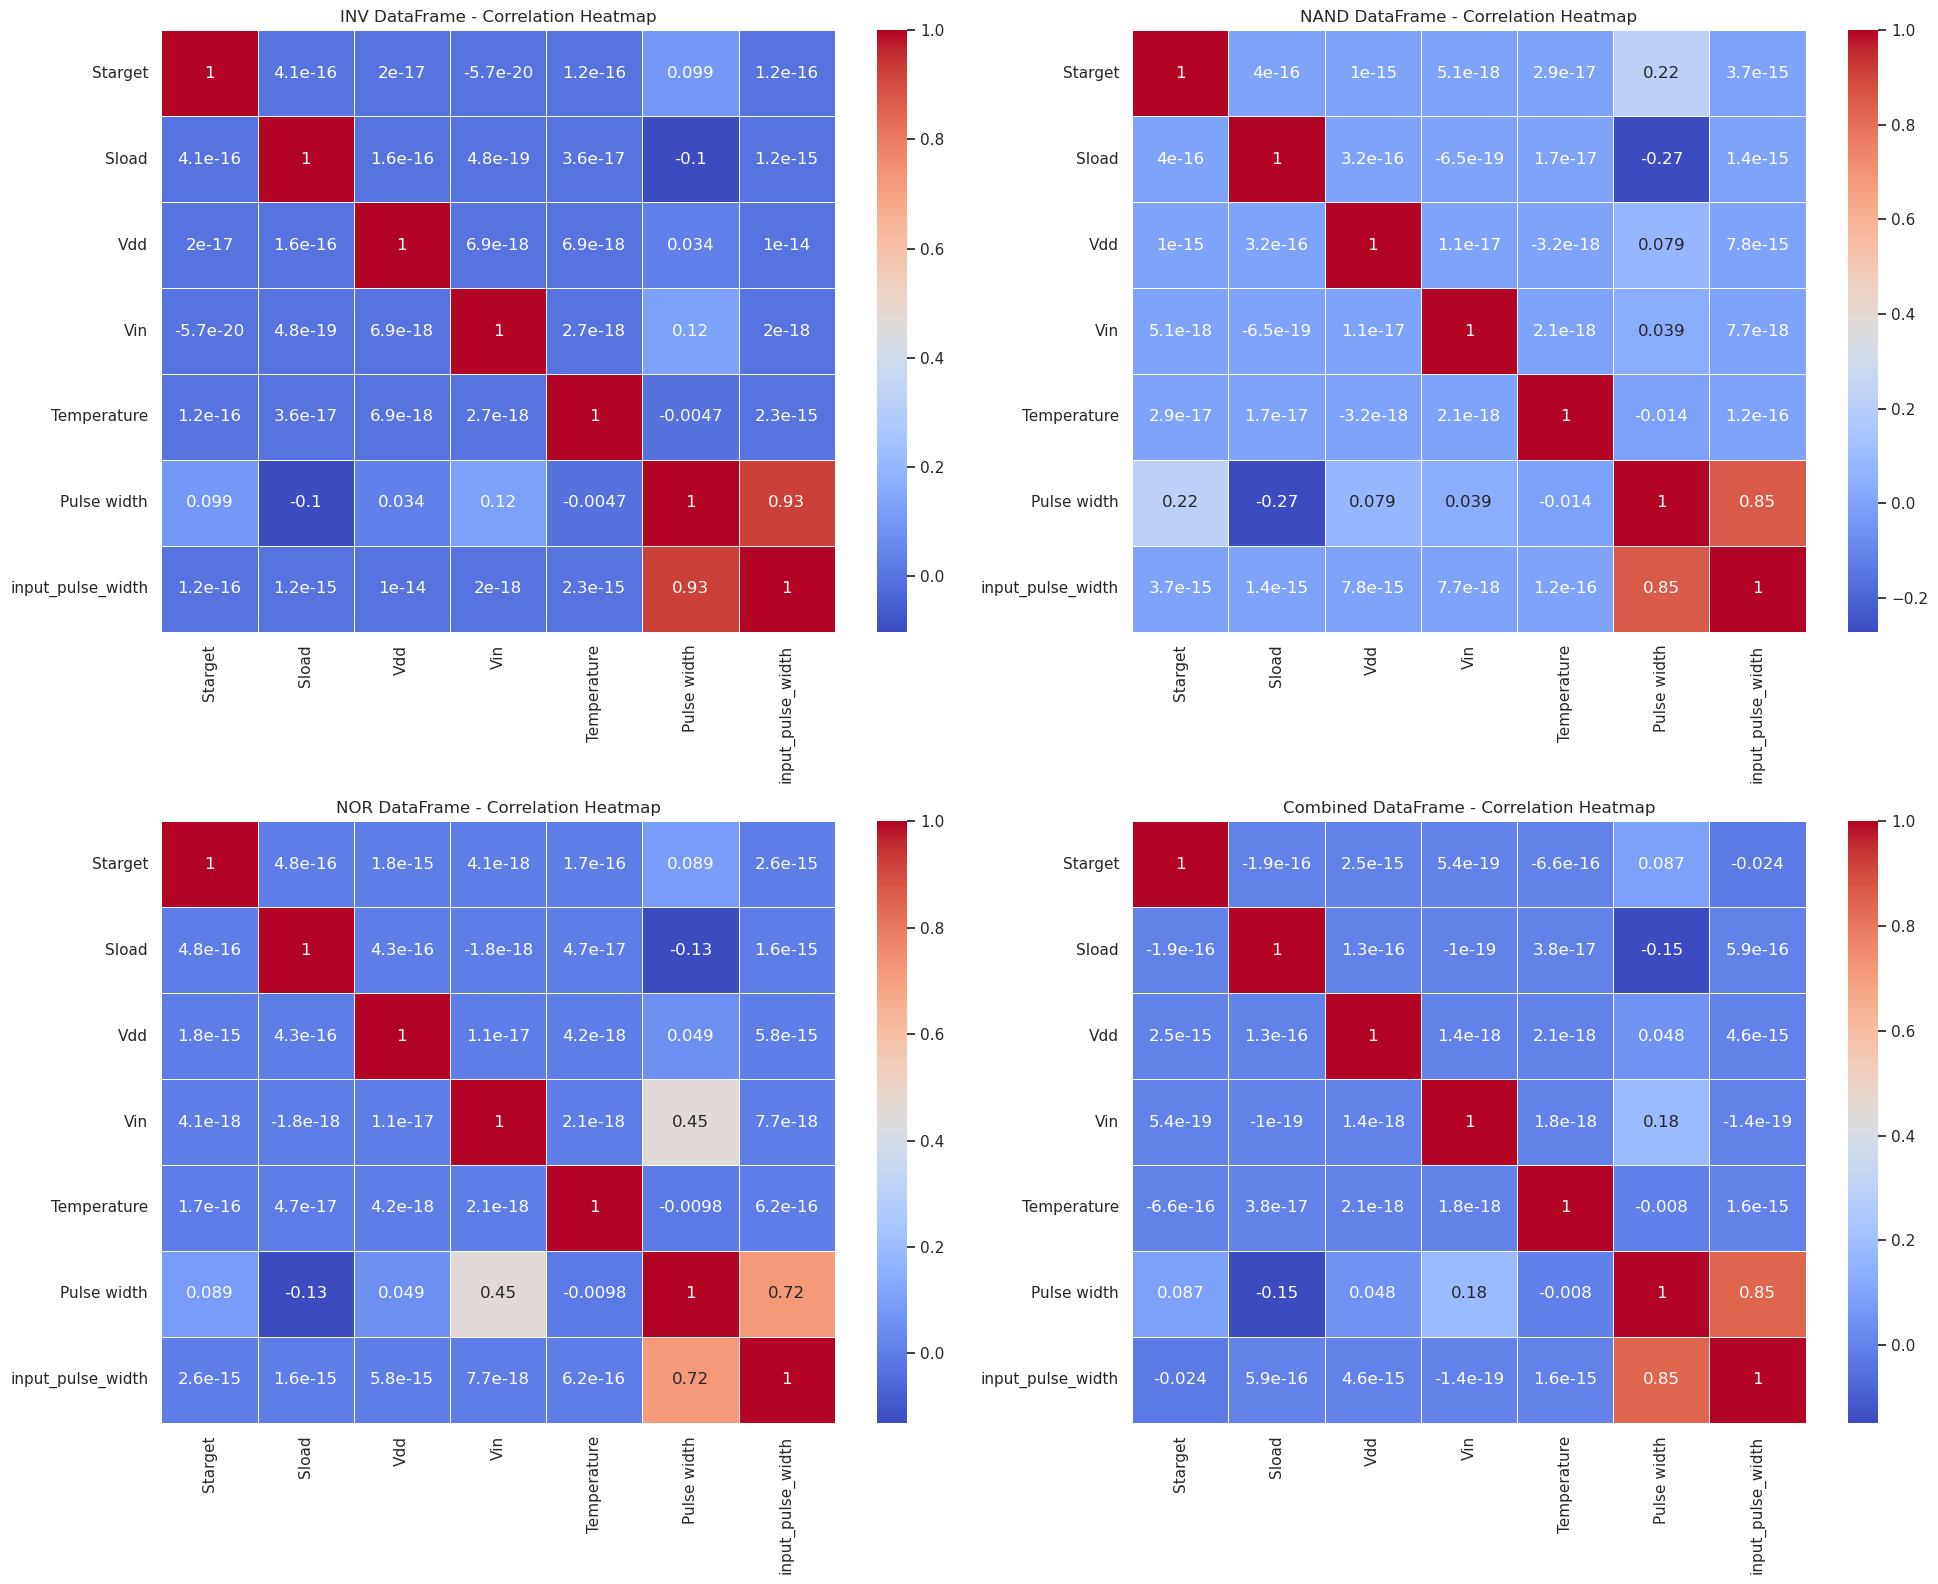

In [44]:
# 2. Correlation Heatmap for Each DataFrame

# Function to select only numerical columns
def get_numeric_corr(dataframe):
    numeric_df = dataframe.select_dtypes(include='number')
    return numeric_df.corr()

# Plot correlation heatmaps for each dataset
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
sns.heatmap(get_numeric_corr(inv_df), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('INV DataFrame - Correlation Heatmap')

plt.subplot(2, 2, 2)
sns.heatmap(get_numeric_corr(nand_df), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('NAND DataFrame - Correlation Heatmap')

plt.subplot(2, 2, 3)
sns.heatmap(get_numeric_corr(nor_df), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('NOR DataFrame - Correlation Heatmap')

plt.subplot(2, 2, 4)
sns.heatmap(get_numeric_corr(combined_df), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Combined DataFrame - Correlation Heatmap')

plt.tight_layout()
plt.show()

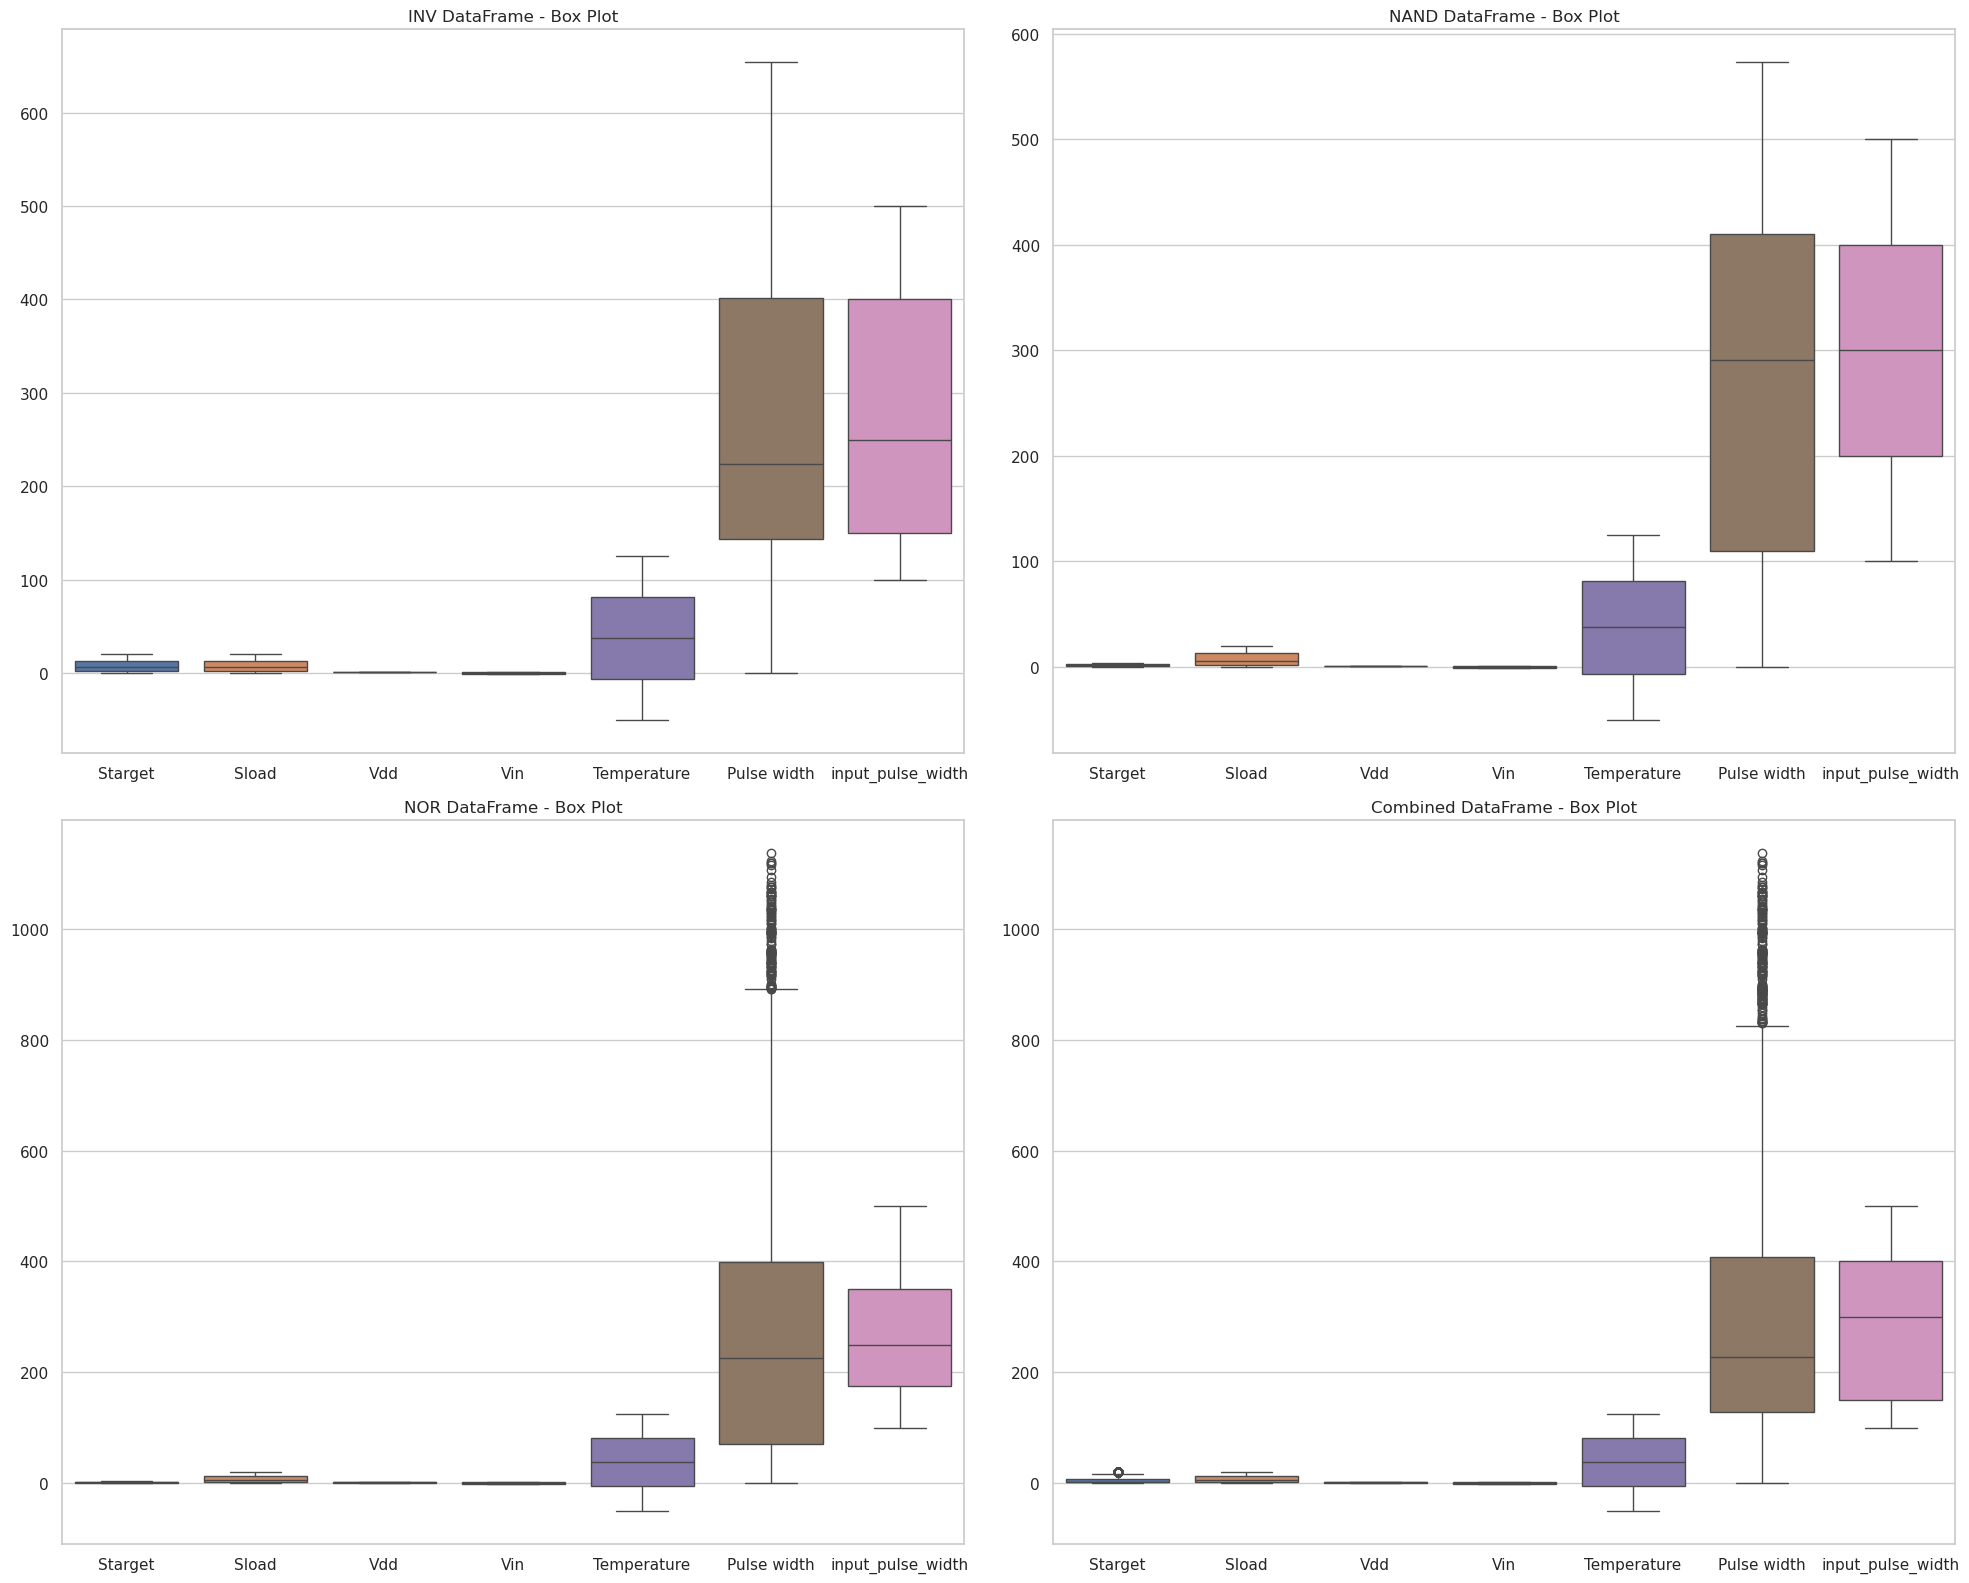

In [45]:
# 3. Box Plot for Each DataFrame
# Box Plot:
# - A box plot is a graphical representation used to summarize the distribution of a dataset, focusing on central tendency, dispersion, and outliers.
# - It includes several key components:
#   1. **Median (Central Line in Box)**: Represents the middle value of the data, indicating the central tendency.
#   2. **Quartiles (Box Edges)**: The box edges represent the lower quartile (Q1, 25%) and the upper quartile (Q3, 75%), indicating the middle 50% of the data.
#   3. **Interquartile Range (IQR)**: This is the range between Q1 and Q3, representing the spread of the middle half of the dataset.
#   4. **Whiskers**: The lines extending from the box represent the typical range of the data, generally defined as Q1 - 1.5*IQR and Q3 + 1.5*IQR. They indicate the variability of the data excluding outliers.
#   5. **Outliers**: Data points beyond the whiskers are plotted as individual points and are considered outliers. These points represent values significantly different from the rest of the data.
# - Box plots are useful for comparing the distributions of different features, identifying the presence of outliers, and understanding the spread and symmetry of the data.

# Plot box plots for each dataset
plt.figure(figsize=(20, 16))

plt.subplot(2, 2, 1)
sns.boxplot(data=inv_df)
plt.title('INV DataFrame - Box Plot')

plt.subplot(2, 2, 2)
sns.boxplot(data=nand_df)
plt.title('NAND DataFrame - Box Plot')

plt.subplot(2, 2, 3)
sns.boxplot(data=nor_df)
plt.title('NOR DataFrame - Box Plot')

plt.subplot(2, 2, 4)
sns.boxplot(data=combined_df)
plt.title('Combined DataFrame - Box Plot')

plt.tight_layout()
plt.show()

### 2.3 Training & Dataset Define

In [46]:
# Function to split dataset into training and testing sets without modifying the original DataFrame
def split_data(df, target_column, test_size=0.2, random_state=42):
    """
    Splits the provided DataFrame into training and testing sets.

    Args:
        df (pd.DataFrame): The input DataFrame to split.
        target_column (str): The name of the column to predict (target variable).
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target variable.
        y_test (pd.Series): Testing target variable.
    """
    # Creating a copy to ensure original data remains unchanged
    df_copy = df.copy()
    
    # Separating features and target variable
    X = df_copy.drop(columns=[target_column])
    y = df_copy[target_column]
    
    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

# Split inv_df
X_train_inv, X_test_inv, y_train_inv, y_test_inv = split_data(inv_df, target_column='Pulse width')

# Split nand_df
X_train_nand, X_test_nand, y_train_nand, y_test_nand = split_data(nand_df, target_column='Pulse width')

# Split nor_df
X_train_nor, X_test_nor, y_train_nor, y_test_nor = split_data(nor_df, target_column='Pulse width')

# Split combined_df
X_train_combined, X_test_combined, y_train_combined, y_test_combined = split_data(combined_df, target_column='Pulse width')

# Display the shapes of the training and testing sets for each DataFrame
{
    "inv_df": (X_train_inv.shape, X_test_inv.shape, y_train_inv.shape, y_test_inv.shape),
    "nand_df": (X_train_nand.shape, X_test_nand.shape, y_train_nand.shape, y_test_nand.shape),
    "nor_df": (X_train_nor.shape, X_test_nor.shape, y_train_nor.shape, y_test_nor.shape),
    "combined_df": (X_train_combined.shape, X_test_combined.shape, y_train_combined.shape, y_test_combined.shape)
}

{'inv_df': ((24576, 7), (6144, 7), (24576,), (6144,)),
 'nand_df': ((10240, 7), (2560, 7), (10240,), (2560,)),
 'nor_df': ((8192, 7), (2048, 7), (8192,), (2048,)),
 'combined_df': ((43008, 7), (10752, 7), (43008,), (10752,))}

## 3 Machine Learning Setting

### 3.1 Machine Learning Model Selection

In [47]:
# One-Hot Encoding for 'gate_type' column
def encode_features(X_train, X_test, categorical_columns):
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns)
    
    # Handle possible mismatch in columns after encoding
    X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)
    
    return X_train_encoded, X_test_encoded

In [48]:
# Define parameter grids for different groups of models
param_grids_set_1 = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {
            "alpha": [0.1, 1, 10]
        }
    },
    "Lasso Regression": {
        "model": Lasso(),
        "params": {
            "alpha": [0.1, 1, 10]
        }
    }
}

In [49]:
param_grids_set_2 = {
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [100, 200, 1000],
            "max_depth": [10, 20, None]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingRegressor(),
        "params": {
            "n_estimators": [100, 200],
            "learning_rate": [0.01, 0.1, 0.2]
        }
    }
}

In [50]:
param_grids_set_3 = {
    "SVR": {
        "model": SVR(),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ['linear', 'rbf']
        }
    },
    "MLP Regressor": {
        "model": MLPRegressor(max_iter=1000),
        "params": {
            "hidden_layer_sizes": [(50,), (100,)],
            "activation": ['relu', 'tanh'],
            "learning_rate": ['constant', 'adaptive']
        }
    }
}

In [51]:
from xgboost import XGBRegressor

param_grids_set_4 = {
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "n_estimators": [100, 200, 500],
            "learning_rate": [0.01, 0.1, 0.2],
            "max_depth": [3, 6, 10]
        }
    }
}

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

param_grids_set_5 = {
    "CatBoost": {
        "model": CatBoostRegressor(verbose=0),
        "params": {
            "iterations": [100, 200, 500],
            "learning_rate": [0.01, 0.1, 0.2],
            "depth": [4, 6, 10]
        }
    },
    "LightGBM": {
        "model": LGBMRegressor(),
        "params": {
            "n_estimators": [100, 200, 500],
            "learning_rate": [0.01, 0.1, 0.2],
            "num_leaves": [20, 31, 50]
        }
    }
}

In [52]:
# Define parameter grids for different groups of models
param_grids_set_test = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {}
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "n_estimators": [100],
            "max_depth": [10, 20, None]
        }
    }
}

In [53]:
# Function to dynamically select models for training based on research topic
def select_model_param_grids(model_groups):
    available_grids = {
        "set_1": param_grids_set_1,
        "set_2": param_grids_set_2,
        "set_3": param_grids_set_3,
        "set_4": param_grids_set_4,
        "set_5": param_grids_set_5,
        "set_test": param_grids_set_test,
    }
    
    selected_grids = {}
    
    for group in model_groups:
        selected_grids.update(available_grids[group])
        
    return selected_grids

### 3.2 Evaluation Method (Predefine)

In [54]:
# Function to calculate total parameter combinations
def calculate_total_combinations(param_grid):
    # Skip models without any hyperparameters to tune
    if not param_grid:  # param_grid is empty
        return 0
    keys, values = zip(*param_grid.items())
    combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
    return len(combinations)

# Function to handle models with or without hyperparameter tuning
def tune_and_evaluate_model_random(X_train, y_train, X_test, y_test, model, param_grid, cv=3, max_iter=10, dataset_type="inv"):
    total_combinations = calculate_total_combinations(param_grid)
    
    # If no hyperparameters to tune, directly train the model without RandomizedSearchCV
    if total_combinations == 0:
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        return evaluate_regression_results(model, X_test, y_test, predictions, dataset_type)
    
    # Set n_iter to the smaller value between total_combinations and max_iter
    n_iter = min(total_combinations, max_iter)
    
    randomized_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=cv,
                                           scoring='neg_mean_squared_error', n_jobs=2)
    randomized_search.fit(X_train, y_train)
    best_model = randomized_search.best_estimator_
    predictions = best_model.predict(X_test)
    
    return evaluate_regression_results(best_model, X_test, y_test, predictions, dataset_type)

# Function to evaluate regression results and return detailed metrics
def evaluate_regression_results(model, X_test, y_test, predictions, dataset_type):
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    explained_var = explained_variance_score(y_test, predictions)
    
    # Generate and save regression plots
    save_regression_plots(y_test, predictions, model, dataset_type)
    # Save predicted vs actual values
    save_predicted_vs_actual(y_test, predictions, model, dataset_type)
    
    return model, mse, r2, mae, explained_var

### 3.3 Results Analysis & Save

In [55]:
# Function to save regression plots
def save_regression_plots(y_test, predictions, model, dataset_type):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal fit line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{dataset_type.upper()} Dataset Regression Results for {type(model).__name__} Model')
    plt.grid(True)
    plt.tight_layout()
    
    # Use a timestamp-based unique folder name for each run
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    subfolder = os.path.join("results", f"{dataset_type}_{timestamp}")
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
    plot_filename = f'{dataset_type}_regression_plot_{type(model).__name__}.png'
    plt.savefig(os.path.join(subfolder, plot_filename))
    plt.close()

# Function to save predicted vs actual values
def save_predicted_vs_actual(y_test, predictions, model, dataset_type):
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    subfolder = os.path.join("results", f"{dataset_type}_{timestamp}")
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
    
    # Create a DataFrame with true and predicted values
    results_df = pd.DataFrame({
        'True SET Pulse Width': y_test,
        'Predicted SET Pulse Width': predictions
    })
    
    # Save to CSV file
    file_name = f'{dataset_type}_predicted_vs_actual_{type(model).__name__}.csv'
    file_path = os.path.join(subfolder, file_name)
    results_df.to_csv(file_path, index=False)
    print(f"Predicted vs Actual results saved to {file_path}")


# Function to save results to a detailed file in the results folder
def save_results_to_file(results_df, param_grids, best_models, folder="results", experiment_name="model_comparison", dataset_type="inv"):
    # Create a subfolder under the results folder for each run using a timestamp-based name
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    subfolder = os.path.join(folder, f"{dataset_type}_{timestamp}")
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)

    # Generate a descriptive file name
    model_names = "_".join(param_grids.keys())  # Join all model names
    file_name = f"{dataset_type}_{experiment_name}_{model_names}.csv"
    file_path = os.path.join(subfolder, file_name)
    
    # Save the results DataFrame as a CSV file
    results_df.to_csv(file_path, index=False)
    
    # Save the best models using joblib
    for model_name, best_model in best_models.items():
        model_filename = f"{dataset_type}_{experiment_name}_{model_name}.pkl"
        joblib.dump(best_model, os.path.join(subfolder, model_filename))
    
    print(f"Results saved to {file_path}")


In [56]:
# Function to evaluate all models with hyperparameter tuning and cross-validation
def evaluate_all_models_with_tuning(param_grids, X_train, y_train, X_test, y_test, dataset_type="inv"):
    results = []
    best_models = {}
    for model_name, model_info in param_grids.items():
        model = model_info["model"]
        param_grid = model_info["params"]
        best_model, mse, r2, mae, explained_var = tune_and_evaluate_model_random(X_train, y_train, X_test, y_test, model, param_grid, dataset_type=dataset_type)
        results.append({
            "Model": model_name,
            "Best Model": best_model,
            "MSE": mse,
            "R²": r2,
            "MAE": mae,
            "Explained Variance": explained_var
        })
        best_models[model_name] = best_model
    return pd.DataFrame(results), best_models

# Function to evaluate and save all models' results
def evaluate_and_save_all_models(param_grids, X_train, y_train, X_test, y_test, experiment_name="model_comparison", dataset_type="inv"):
    # Evaluate all models
    results_df, best_models = evaluate_all_models_with_tuning(param_grids, X_train, y_train, X_test, y_test, dataset_type=dataset_type)
    
    # Save the results to the results folder
    save_results_to_file(results_df, param_grids, best_models, experiment_name=experiment_name, dataset_type=dataset_type)
    
    return results_df

In [57]:
# Example usage:
# Step 1:  Select which model sets to use for the current research topic
# For example, select models from 'set_1' and 'set_2'
# selected_param_grids = select_model_param_grids(['set_1', 'set_2'])
selected_param_grids = select_model_param_grids(['set_test'])

# Step 2: One-hot encode the 'gate_type' column
X_train_encoded, X_test_encoded = encode_features(X_train_inv, X_test_inv, categorical_columns=['gate_type'])

# Step 3: Call the evaluation and save function
model_results_tuned = evaluate_and_save_all_models(selected_param_grids, X_train_encoded, y_train_inv, X_test_encoded, y_test_inv, experiment_name="PulseWidthPrediction", dataset_type="inv")

# Step 4: Display the results (already saved)
print(model_results_tuned)

Predicted vs Actual results saved to results/inv_2024-10-09_11-40/inv_predicted_vs_actual_LinearRegression.csv
Predicted vs Actual results saved to results/inv_2024-10-09_11-40/inv_predicted_vs_actual_RandomForestRegressor.csv
Results saved to results/inv_2024-10-09_11-40/inv_PulseWidthPrediction_Linear Regression_Random Forest.csv
               Model                                         Best Model  \
0  Linear Regression                                 LinearRegression()   
1      Random Forest  (DecisionTreeRegressor(max_depth=20, max_featu...   

           MSE        R²        MAE  Explained Variance  
0  2682.892659  0.887553  32.112439            0.887553  
1     6.226873  0.999739   0.862846            0.999739  


## 4. Research Items

### 4.1 Individual Type Forecasts

#### 4.1.1 INV Gate

In [58]:
# Step 1:  Select which model sets to use for the current research topic
selected_param_grids = select_model_param_grids(['set_1', 'set_2','set_3','set_4','set_5'])

# Step 2: One-hot encode the 'gate_type' column
X_train_encoded, X_test_encoded = encode_features(X_train_inv, X_test_inv, categorical_columns=['gate_type'])

# Step 3: Call the evaluation and save function
model_results_tuned = evaluate_and_save_all_models(selected_param_grids, X_train_encoded, y_train_inv, X_test_encoded, y_test_inv, experiment_name="Individual_INV_PulseWidthPrediction", dataset_type="inv")

# Step 4: Display the results (already saved)
print(model_results_tuned)

Predicted vs Actual results saved to results/inv_2024-10-09_11-43/inv_predicted_vs_actual_LinearRegression.csv
Predicted vs Actual results saved to results/inv_2024-10-09_11-43/inv_predicted_vs_actual_Ridge.csv
Predicted vs Actual results saved to results/inv_2024-10-09_11-43/inv_predicted_vs_actual_Lasso.csv


/home/user/Chen/Software/anaconda3/envs/ml_project_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Predicted vs Actual results saved to results/inv_2024-10-09_11-46/inv_predicted_vs_actual_RandomForestRegressor.csv
Predicted vs Actual results saved to results/inv_2024-10-09_11-46/inv_predicted_vs_actual_GradientBoostingRegressor.csv
Predicted vs Actual results saved to results/inv_2024-10-09_12-10/inv_predicted_vs_actual_SVR.csv
Predicted vs Actual results saved to results/inv_2024-10-09_12-17/inv_predicted_vs_actual_MLPRegressor.csv
Predicted vs Actual results saved to results/inv_2024-10-09_12-18/inv_predicted_vs_actual_XGBRegressor.csv


/home/user/Chen/Software/anaconda3/envs/ml_project_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Predicted vs Actual results saved to results/inv_2024-10-09_12-18/inv_predicted_vs_actual_CatBoostRegressor.csv
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 24576, number of used features: 6
[LightGBM] [Info] Start training from score 270.250314
Predicted vs Actual results saved to results/inv_2024-10-09_12-18/inv_predicted_vs_actual_LGBMRegressor.csv
Results saved to results/inv_2024-10-09_12-18/inv_Individual_INV_PulseWidthPrediction_Linear Regression_Ridge Regression_Lasso Regression_Random Forest_Gradient Boosting_SVR_MLP Regressor_XGBoost_CatBoost_LightGBM.csv
               Model                                         Best Model  \
0  Linear Regression                                 LinearRegression()   
1   Rid

#### 4.1.2 Nor Gate

In [29]:
# Step 1:  Select which model sets to use for the current research topic
selected_param_grids = select_model_param_grids(['set_1', 'set_2','set_3','set_4','set_5'])

# Step 2: One-hot encode the 'gate_type' column
X_train_encoded, X_test_encoded = encode_features(X_train_nor, X_test_nor, categorical_columns=['gate_type'])

# Step 3: Call the evaluation and save function
model_results_tuned = evaluate_and_save_all_models(selected_param_grids, X_train_encoded, y_train_nor, X_test_encoded, y_test_nor, experiment_name="Individual_NOR_PulseWidthPrediction", dataset_type="nor")

# Step 4: Display the results (already saved)
print(model_results_tuned)

Predicted vs Actual results saved to results/nor_2024-10-07_19-46/nor_predicted_vs_actual_LinearRegression.csv
Predicted vs Actual results saved to results/nor_2024-10-07_19-46/nor_predicted_vs_actual_Ridge.csv
Predicted vs Actual results saved to results/nor_2024-10-07_19-46/nor_predicted_vs_actual_Lasso.csv
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 16384, number of used features: 6
[LightGBM] [Info] Start training from score 270.162923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number o

/home/user/Chen/Software/anaconda3/envs/ml_project_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Predicted vs Actual results saved to results/nor_2024-10-07_19-46/nor_predicted_vs_actual_RandomForestRegressor.csv
Predicted vs Actual results saved to results/nor_2024-10-07_19-46/nor_predicted_vs_actual_GradientBoostingRegressor.csv
Predicted vs Actual results saved to results/nor_2024-10-07_19-49/nor_predicted_vs_actual_SVR.csv
Predicted vs Actual results saved to results/nor_2024-10-07_19-53/nor_predicted_vs_actual_MLPRegressor.csv
Predicted vs Actual results saved to results/nor_2024-10-07_19-53/nor_predicted_vs_actual_XGBRegressor.csv
Predicted vs Actual results saved to results/nor_2024-10-07_19-53/nor_predicted_vs_actual_CatBoostRegressor.csv
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 16384, number of used fe

#### 4.1.3 NAND Gate

In [32]:
# Step 1:  Select which model sets to use for the current research topic
selected_param_grids = select_model_param_grids(['set_1', 'set_2','set_3','set_4','set_5'])

# Step 2: One-hot encode the 'gate_type' column
X_train_encoded, X_test_encoded = encode_features(X_train_nand, X_test_nand, categorical_columns=['gate_type'])

# Step 3: Call the evaluation and save function
model_results_tuned = evaluate_and_save_all_models(selected_param_grids, X_train_encoded, y_train_nand, X_test_encoded, y_test_nand, experiment_name="Individual_NAND_PulseWidthPrediction", dataset_type="nand")

# Step 4: Display the results (already saved)
print(model_results_tuned)

Predicted vs Actual results saved to results/nand_2024-10-07_20-22/nand_predicted_vs_actual_LinearRegression.csv
Predicted vs Actual results saved to results/nand_2024-10-07_20-22/nand_predicted_vs_actual_Ridge.csv
Predicted vs Actual results saved to results/nand_2024-10-07_20-22/nand_predicted_vs_actual_Lasso.csv


/home/user/Chen/Software/anaconda3/envs/ml_project_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Predicted vs Actual results saved to results/nand_2024-10-07_20-23/nand_predicted_vs_actual_RandomForestRegressor.csv
Predicted vs Actual results saved to results/nand_2024-10-07_20-24/nand_predicted_vs_actual_GradientBoostingRegressor.csv
Predicted vs Actual results saved to results/nand_2024-10-07_20-29/nand_predicted_vs_actual_SVR.csv
Predicted vs Actual results saved to results/nand_2024-10-07_20-33/nand_predicted_vs_actual_MLPRegressor.csv
Predicted vs Actual results saved to results/nand_2024-10-07_20-33/nand_predicted_vs_actual_XGBRegressor.csv
Predicted vs Actual results saved to results/nand_2024-10-07_20-33/nand_predicted_vs_actual_CatBoostRegressor.csv
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 43
[LightGBM] [Info] Number of data points in the train set: 10240, numbe

#### 4.1.4 All Gate

In [59]:
# Step 1:  Select which model sets to use for the current research topic
selected_param_grids = select_model_param_grids(['set_1', 'set_2','set_3','set_4','set_5'])

# Step 2: One-hot encode the 'gate_type' column
X_train_encoded, X_test_encoded = encode_features(X_train_combined, X_test_combined, categorical_columns=['gate_type'])

# Step 3: Call the evaluation and save function
model_results_tuned = evaluate_and_save_all_models(selected_param_grids, X_train_encoded, y_train_combined, X_test_encoded, y_test_combined, experiment_name="Individual_COMBINED_PulseWidthPrediction",dataset_type="combined")

# Step 4: Display the results (already saved)
print(model_results_tuned)

Predicted vs Actual results saved to results/combined_2024-10-09_12-18/combined_predicted_vs_actual_LinearRegression.csv
Predicted vs Actual results saved to results/combined_2024-10-09_12-18/combined_predicted_vs_actual_Ridge.csv
Predicted vs Actual results saved to results/combined_2024-10-09_12-18/combined_predicted_vs_actual_Lasso.csv
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 16384, number of used features: 6
[LightGBM] [Info] Start training from score 270.162923
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

/home/user/Chen/Software/anaconda3/envs/ml_project_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Predicted vs Actual results saved to results/combined_2024-10-09_12-23/combined_predicted_vs_actual_RandomForestRegressor.csv
Predicted vs Actual results saved to results/combined_2024-10-09_12-23/combined_predicted_vs_actual_GradientBoostingRegressor.csv
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 16384, number of used features: 6
[LightGBM] [Info] Start training from score 271.187937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 48
[LightGBM] [Info] Number of data points in the train set: 16384, number of used f

/home/user/Chen/Software/anaconda3/envs/ml_project_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Predicted vs Actual results saved to results/combined_2024-10-09_13-17/combined_predicted_vs_actual_CatBoostRegressor.csv
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 43008, number of used features: 9
[LightGBM] [Info] Start training from score 267.051007
Predicted vs Actual results saved to results/combined_2024-10-09_13-17/combined_predicted_vs_actual_LGBMRegressor.csv
Results saved to results/combined_2024-10-09_13-17/combined_Individual_COMBINED_PulseWidthPrediction_Linear Regression_Ridge Regression_Lasso Regression_Random Forest_Gradient Boosting_SVR_MLP Regressor_XGBoost_CatBoost_LightGBM.csv
               Model                                         Best Model  \
0  Linear Regression                           

#### More: Verify with K-fold

In [62]:
from sklearn.model_selection import KFold

# 创建5折交叉验证器
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to evaluate and save all models' results using KFold cross-validation
def evaluate_and_save_all_models_kfold(param_grids, X, y, experiment_name="model_comparison", dataset_type="combined"):
    # Create an empty list to store the results
    all_results = []
    best_models = {}

    # Iterate through each fold of the KFold split
    fold = 1
    for train_index, test_index in kf.split(X):
        print(f"Evaluating Fold {fold} ...")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Evaluate all models on this fold
        results_df, fold_best_models = evaluate_all_models_with_tuning(param_grids, X_train, y_train, X_test, y_test, dataset_type=dataset_type)
        results_df['Fold'] = fold  # Add fold information
        all_results.append(results_df)

        # Save the best models for each fold
        for model_name, model in fold_best_models.items():
            if model_name not in best_models:
                best_models[model_name] = []
            best_models[model_name].append(model)
        
        fold += 1

    # Combine results from all folds
    combined_results_df = pd.concat(all_results)

    # Save the combined results to a CSV file
    folder = "results"
    subfolder = os.path.join(folder, "SourceData")
    if not os.path.exists(subfolder):
        os.makedirs(subfolder)
    combined_results_filename = f"{dataset_type}_{experiment_name}_kfold_results.csv"
    combined_results_path = os.path.join(subfolder, combined_results_filename)
    combined_results_df.to_csv(combined_results_path, index=False)
    print(f"K-Fold Cross-Validation results saved to {combined_results_path}")

    # Average the metrics over all folds for each model and save
    average_results = combined_results_df.groupby('Model').agg({
        'MSE': 'mean',
        'R²': 'mean',
        'MAE': 'mean',
        'Explained Variance': 'mean'
    }).reset_index()

    average_results_filename = f"{dataset_type}_{experiment_name}_average_results.csv"
    average_results_path = os.path.join(subfolder, average_results_filename)
    average_results.to_csv(average_results_path, index=False)
    print(f"Average Cross-Validation results saved to {average_results_path}")

    return combined_results_df, average_results

# Example usage:
# Step 1: Select which model sets to use for the current research topic
selected_param_grids = select_model_param_grids(['set_1', 'set_2', 'set_3', 'set_4', 'set_5'])

# Step 2: One-hot encode the 'gate_type' column
X_encoded, y_combined = encode_features(X_train_combined, X_test_combined, categorical_columns=['gate_type'])


# Step 3: Call the evaluation and save function with K-Fold Cross-Validation
combined_results, average_results = evaluate_and_save_all_models_kfold(selected_param_grids, X_encoded, y_combined, experiment_name="Individual_COMBINED_PulseWidthPrediction", dataset_type="combined")

# Step 4: Display the average results (already saved)
print(average_results)

Evaluating Fold 1 ...


IndexError: positional indexers are out-of-bounds

### 4.2 Cross Type Forecasts

In [ ]:
# TBD

### 4.3 Individual Type Forecast Different Input Pulse

In [ ]:
# TBD

### 4.4 More ...

In [ ]:
# TBD